# Submission for KDAG Task-2
This is my submission for KDAG Task-2. I have also included some wrong runs in the below which I have either commented for reference.


#### Step-1 - Importing the basic libraries and reading the dataset

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

df = pd.read_csv('TASK2_dataset.csv')

In [110]:
df

,song_id,keyword_1,keyword_2,keyword_3,genre
0,74,guitar,happy,distorted,rock
1,103,brass,energetic,melodic,classical
2,201,banjo,happy,acoustic,country
3,194,synth,energetic,heavy,hip-hop
4,184,synth,energetic,slow,hip-hop
...,...,...,...,...,...
142,195,synth,angry,melodic,hip-hop
143,7,guitar,energetic,fast,pop
144,14,guitar,happy,rhythmic,pop
145,36,synth,mellow,danceable,pop


#### Step-2 - Making a new column called "Combined Keywords" in the Dataframe to help in code

In [111]:
df['combined_keywords']=df['keyword_1']+' '+df['keyword_2']+' '+df['keyword_3']

In [112]:
df

,song_id,keyword_1,keyword_2,keyword_3,genre,combined_keywords
0,74,guitar,happy,distorted,rock,guitar happy distorted
1,103,brass,energetic,melodic,classical,brass energetic melodic
2,201,banjo,happy,acoustic,country,banjo happy acoustic
3,194,synth,energetic,heavy,hip-hop,synth energetic heavy
4,184,synth,energetic,slow,hip-hop,synth energetic slow
...,...,...,...,...,...,...
142,195,synth,angry,melodic,hip-hop,synth angry melodic
143,7,guitar,energetic,fast,pop,guitar energetic fast
144,14,guitar,happy,rhythmic,pop,guitar happy rhythmic
145,36,synth,mellow,danceable,pop,synth mellow danceable


#### Step-3 - Create a vocabulary based on all keywords

In [113]:
def create_vocab(df,col_name):
    vocabl = set()
    for word in df[col_name]:
        for x in word.split():
            vocabl.add(x)
    return sorted(list(vocabl))

vocab = create_vocab(df,'combined_keywords')
vocab1 = create_vocab(df,'keyword_1')
vocab2 = create_vocab(df,'keyword_2')
vocab3 = create_vocab(df,'keyword_3')
genre_vocab = create_vocab(df,'genre')

#### Trial - Playing with vectorization of all the keywords at once

In [114]:
# Trial implementation of TF-IDF using ['combined_keywords'] instead of 3 vectors. Took a lot of trials
def second_tf_idf(df,vocab):
    y = list(vocab)
    y.sort()
    def tf(df,vocab):
        tfidf_vector = np.zeros((df['song_id'].count(),len(vocab)),dtype=float)
        for i in range(0,df['song_id'].count()):
            doc = df.iloc[i]['combined_keywords']
            for word in doc.split(' '):
                tfidf_vector[i,y.index(word)]=1
        return (tfidf_vector/len(doc.split(' ')))

    def idf(vector,vocab):
        for j in range(0,len(vocab)):
            count=0
            for elem in vector[:,j]:
                if (elem!=0):
                    count+=1
            idf_value = math.log(df['song_id'].count()/count)
            vector[:,j] = vector[:,j]*idf_value
            
        return vector
    tfidf_vector = tf(df,vocab)
    return idf(tfidf_vector,vocab)

#### Step-4 - Implementing Tf-Idf on each of the 3 keyword columns to make the 3 vectors

In [115]:
def tf_idf(df,vocab,col_name):
    N=df['song_id'].count()
    word_dict={word:0 for word in vocab}
    vector = np.zeros((N,len(vocab)),dtype=float)
    for i in range(N):
        word = df.iloc[i][col_name]
        vector[i,vocab.index(word)]=1
        word_dict[word]+=1

    for j in range(len(word_dict)):
        vector[:,j] = vector[:,j]*math.log(N/(word_dict[vocab[j]]+1))
    return vector

In [116]:
vector_1 = tf_idf(df,vocab,'keyword_1')
vector_2 = tf_idf(df,vocab,'keyword_2')
vector_3 = tf_idf(df,vocab,'keyword_3')

#### Step-5 - Implementing PCA on all 3 vectors to convert them into 2-dimensional vectors 

In [117]:
def pca(X, n_components=2):
    X = (X-X.mean(axis=0))
    cov_matrix = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    ordered = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[ordered]
    eigenvectors = eigenvectors[:, ordered]
    
    components = eigenvectors[:, :n_components]
    X_transformed = np.dot(X, components)
    return X_transformed

In [118]:
pca_vector_1 = pca(vector_1)
pca_vector_2 = pca(vector_2)
pca_vector_3 = pca(vector_3)

#### Step-6 - Combining all 3 vectors into 1 by taking average of all three

In [119]:
pca_vector = (pca_vector_1+pca_vector_2+pca_vector_3)/3

#### Step-7 - Plotting the scatter graph of the combined pca vector

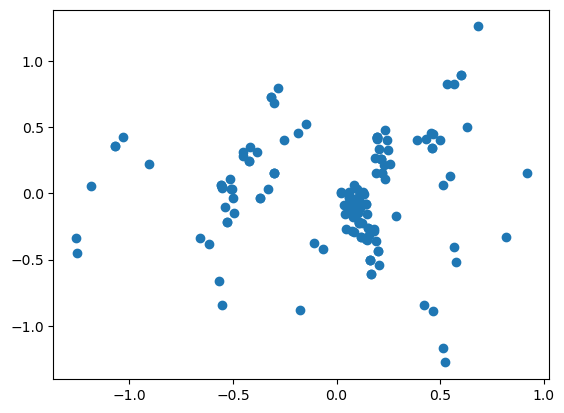

In [120]:
plt.scatter(pca_vector[:,0],pca_vector[:,1])

In [121]:
np.shape(pca_vector)

(147, 2)

#### Step-8 - Using K-means to cluster data

In [122]:
class Kmeans:
    def __init__(self, K):
        self.K = K
        
    def initialize_centroids(self, X):
        randomised = np.random.permutation(X.shape[0]) 
        self.centroids = X[randomised[:self.K]]
        
    def assign_points_centroids(self, X):
        X = np.expand_dims(X, axis=1)
        distance = np.linalg.norm((X - self.centroids), axis=-1)
        points = np.argmin(distance, axis=1)
        return points
    
    def compute_mean(self, X, points):
        centroids = np.zeros((self.K, X.shape[1]))
        for i in range(self.K):
            centroid_mean = X[points == i].mean(axis=0)
            centroids[i] = centroid_mean
        return centroids
        
    def fit(self, X, iterations=100):      
        self.initialize_centroids(X) # initializing centroids
        for i in range(iterations):
            points = self.assign_points_centroids(X) # assigning all points to their nearest centroid
            self.centroids = self.compute_mean(X, points) # compute new centroids based on the mean of their points
        return self.centroids, points

    def calculate_wcss(self, X, points):
        wcss = 0
        for i in range(self.K):
            cluster_points = X[points == i]
            if len(cluster_points) > 0:
                centroid = self.centroids[i]
                wcss += np.sum(np.square(np.linalg.norm(cluster_points - centroid, axis=1)))
        return wcss

#### Step-9 - Using Elbow Method to determine the number of clusters(K)

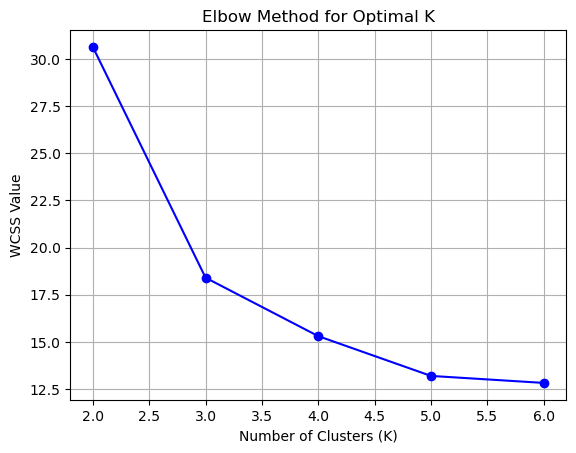

In [135]:
def elbow_method(X, k_range, iterations=100):
    wcss_values = []
    
    for k in k_range:
        kmeans = Kmeans(k)
        centroids, points = kmeans.fit(X, iterations)
        wcss = kmeans.calculate_wcss(X, points)
        wcss_values.append(wcss)

    plt.plot(k_range, wcss_values, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('WCSS Value')
    plt.title('Elbow Method for Optimal K')
    plt.grid(True)
    plt.show()
    
    return wcss_values

wcss_values = elbow_method(pca_vector, range(2,7))

#### Step-10 - Plotting the final clustred results 
##### Also, as the initial value of k is random, the plot will change on each run

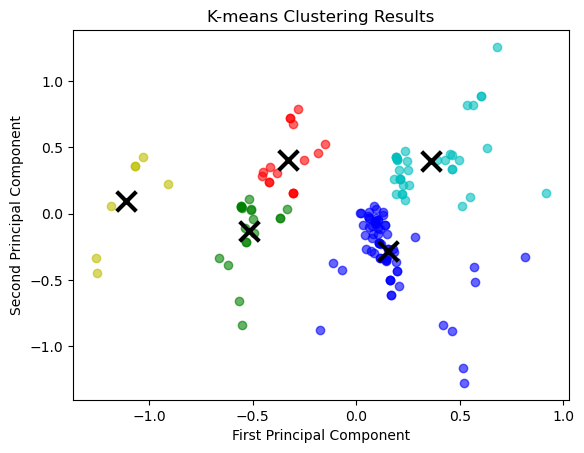

In [136]:
kmeans = Kmeans(5)
centroids,points = kmeans.fit(pca_vector,1000)
cmp = ['r','b','g','y','c','orange','purple','brown','pink','gray']
for i in range(len(points)):
    plt.scatter(pca_vector[i][0],pca_vector[i][1],c=cmp[points[i]],alpha=0.6)
for centroid in centroids:
    plt.scatter(centroid[0],centroid[1],c='black',marker='x',s=200,linewidths=3,label='Centroids')

plt.title('K-means Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

## Analysis

#### Percentage Distribution of ground truth genres in each cluster

In [138]:
df['cluster'] = points
unique_clusters = np.unique(points)
unique_genres = df['genre'].unique()

cluster_genre_distribution = pd.DataFrame(index=unique_clusters, columns=unique_genres, dtype=float)
for cluster in unique_clusters:
    cluster_subset = df[df['cluster'] == cluster]['genre'].value_counts(normalize=True) * 100
    cluster_genre_distribution.loc[cluster] = cluster_subset

cluster_genre_distribution = cluster_genre_distribution.fillna(0)
cluster_genre_distribution

,rock,classical,country,hip-hop,pop
0,18.750000,18.750000,25.000000,25.000000,12.500000
1,22.058824,16.176471,17.647059,17.647059,26.470588
2,30.000000,5.000000,20.000000,25.000000,20.000000
3,14.285714,57.142857,14.285714,14.285714,0.000000
4,13.888889,22.222222,22.222222,22.222222,19.444444


#### Calculation of Silhouette Score

In [139]:
def silhouette_score(x, points, centroids):
    n = x.shape[0]
    silhouette_values = np.zeros(n)

    for i in range(n):
        cluster = points[i]
        same = x[points == cluster]
        other_c = [x[points == j] for j in range(len(centroids)) if j != cluster]
        # Mean intra-cluster
        a = np.mean(np.linalg.norm(same - x[i], axis=1))
        # Mean nearest-cluster
        b = np.min([np.mean(np.linalg.norm(other - x[i], axis=1)) for other in other_c if len(other) > 0])

        silhouette_values[i] = (b - a) / max(a, b)

    return np.mean(silhouette_values)


silhouette_score(pca_vector, points, centroids)

0.5034145682465773

#### Genre Classification

For This Part, I thought of appending the new keywords into the dataframe and then doing the whole tf-idf, pca and clustering again to get accurate results. But I couldn't do that. I wasnt successful in doing so.

# END OF FILE